In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# adfuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)  # p<0.05, Stationary

In [3]:
ten_stocks_close = pd.read_csv('close_df.csv')

In [4]:
pool = ["600094.XSHG",    
        "600160.XSHG", 
        "600008.XSHG",
        "600903.XSHG",
        "000959.XSHE",
        "600970.XSHG",
        "002302.XSHE",
        "600823.XSHG",
        "002503.XSHE",
        "600664.XSHG"]

In [5]:
close_price = ten_stocks_close['600160.XSHG']

## Ljung Box Test on close price

In [6]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(close_price, lags=[12], return_df=True) # The p-value closes to 0. Has dependency

,lb_stat,lb_pvalue
12,13425.198966,0.0


## Stationarity on close price first

In [7]:
test_stationarity(close_price) # p-value is just slightly smaller than 0.05

Results of Dickey-Fuller Test:
Test Statistic                   -3.785483
p-value                           0.003059
#Lags Used                       24.000000
Number of Observations Used    1401.000000
Critical Value (1%)              -3.435026
Critical Value (5%)              -2.863605
Critical Value (10%)             -2.567870
dtype: float64


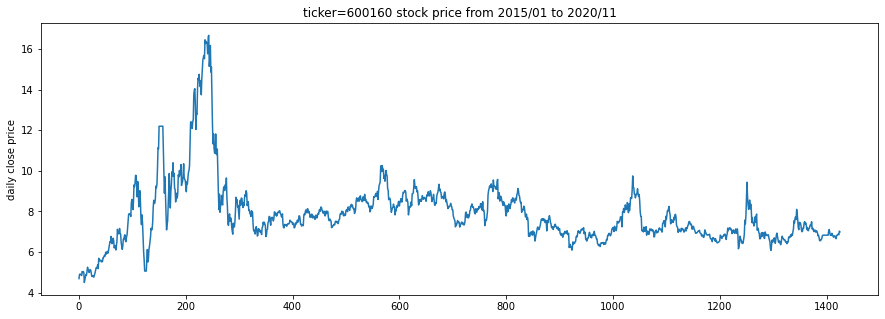

In [8]:
# visualize daily close data, lable y = column 1, ticker = 600094
close_price.plot(figsize=(15,5))
plt.ylabel('daily close price')
plt.title('ticker=600160 stock price from 2015/01 to 2020/11')
plt.show()

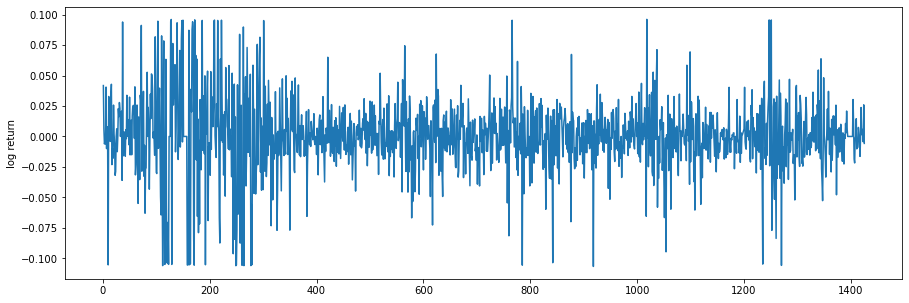

In [9]:
log_rtn = np.log(close_price).diff(1).dropna()
log_rtn.plot(figsize=(15,5))
plt.ylabel('log return')
plt.show()

## Test stationarity

In [10]:
test_stationarity(log_rtn) #p-value is small, it's stationary

Results of Dickey-Fuller Test:
Test Statistic                -9.183175e+00
p-value                        2.223498e-15
#Lags Used                     2.300000e+01
Number of Observations Used    1.401000e+03
Critical Value (1%)           -3.435026e+00
Critical Value (5%)           -2.863605e+00
Critical Value (10%)          -2.567870e+00
dtype: float64


## ACF & PACF

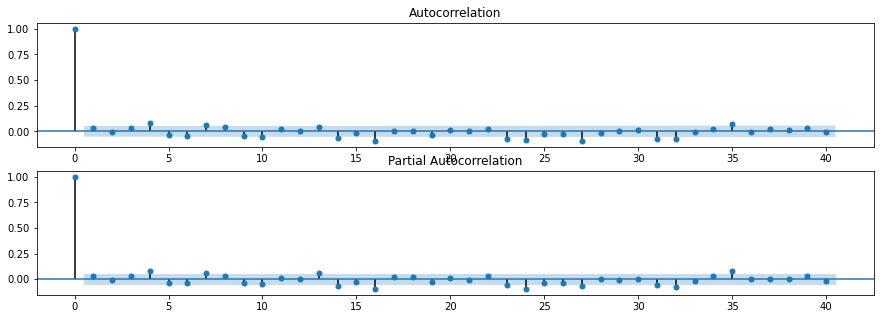

In [11]:
# acf & pacf for log return
import statsmodels.api as sm
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_rtn, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_rtn, lags=40, ax=ax2)

## Distribution of log return

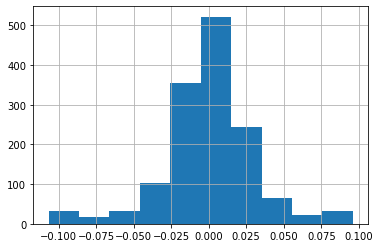

In [12]:
log_rtn.hist()
plt.show()

## Fit ARMA Model

In [13]:
import pandas as pd
import itertools
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA

p = range(5)
q = range(5)

combinations = list(itertools.product(p, q))
combinations = combinations[1:] # Drop (0,0)
def train_ARMA(param):
    try:
        p = param[0]
        q = param[1]
        model = ARIMA(log_rtn, order=(p,0,q))

        model_fit = model.fit(disp=0)

        ljung_p = sm.stats.acorr_ljungbox(model_fit.resid, lags=[12-p-q], return_df=True).values[0][1]
        aic = model_fit.aic
        return {'p': p, 'q': q, 'ljung_p': ljung_p, 'aic': aic}
    except:
        print(param)

results = pd.DataFrame(columns=['p', 'q', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_ARMA(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

,p,q,ljung_p,aic
16,3.0,2.0,0.156371,-5857.123382
12,2.0,3.0,0.142736,-5856.859520
18,3.0,4.0,0.657809,-5855.130850
22,4.0,3.0,0.657734,-5855.130200
23,4.0,4.0,0.778524,-5851.648783
13,2.0,4.0,0.998155,-5843.748761
21,4.0,2.0,0.999932,-5843.011794
19,4.0,0.0,0.279726,-5837.358018
3,0.0,4.0,0.223340,-5836.628602
20,4.0,1.0,0.374189,-5836.165246


## GARCH

In [14]:
mean = log_rtn.mean() # The mean closes to 0

### Check if volatility time dependency

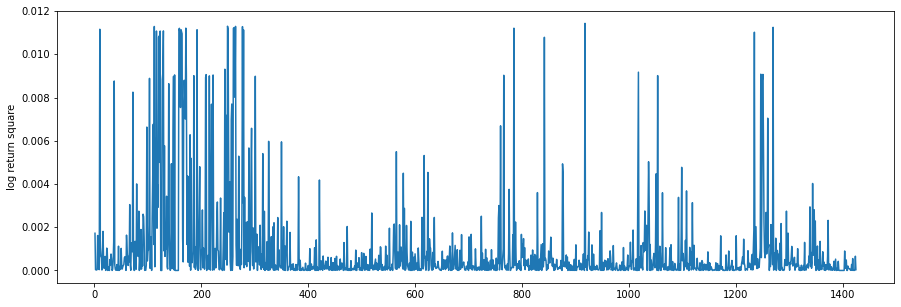

In [15]:
#log return square 
log_rtn_square = np.square(log_rtn - mean)
log_rtn_square.plot(figsize=(15,5))
plt.ylabel('log return square')
plt.show()

In [16]:
import statsmodels.api as sm

p_2 = sm.stats.acorr_ljungbox(log_rtn_square, lags=[40], return_df=True)['lb_pvalue'].values[0] # log return square is white noise if p < 0.05

print(f"P-value for squared log return: {p_2}")
if (p_2<0.05):
    print("Conclusion: Has ARCH's property in log rtn")
else:
    print("Conclusion: No ARCH's property in log rtn")

P-value for squared log return: 0.0
Conclusion: Has ARCH's property in log rtn


In [17]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,4)
q = range(1,4)

combinations = list(itertools.product(p, q))

def train_GARCH(param):
    p = param[0]
    q = param[1]
    model = arch_model(log_rtn, mean='constant', p=p, q=q)
    
    res = model.fit(update_freq=0)
    
    ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
    aic = res.aic
    
    return {'p':p, 'q': q, 'alpha': res.params['alpha[1]'], 'beta': res.params['beta[1]'], 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'alpha', 'beta', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_GARCH(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3150.865125054229
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3154.163187623858
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3151.3449545429344
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3147.592391330789
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3149.169398349376
            Iterations: 6
            Function evaluations

,p,q,alpha,beta,ljung_p,aic
1,1.0,2.0,0.100000,0.440000,0.245468,-6298.326375
0,1.0,1.0,0.100000,0.880000,0.265961,-6293.730250
2,1.0,3.0,0.100000,0.293333,0.220791,-6290.689909
4,2.0,2.0,0.050000,0.440000,0.240768,-6286.338797
3,2.0,1.0,0.050000,0.880000,0.254689,-6285.184783
7,3.0,2.0,0.033333,0.440000,0.227459,-6282.833455
6,3.0,1.0,0.033377,0.879960,0.249752,-6282.335035
8,3.0,3.0,0.066646,0.259918,0.252871,-6279.925847
5,2.0,3.0,0.050000,0.293333,0.214908,-6277.839035


## EGARCH

In [18]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,4)
q = range(1,4)

combinations = list(itertools.product(p, q))

def train_EGARCH(param):
    p = param[0]
    q = param[1]
    model = arch_model(log_rtn, vol='EGARCH', mean='constant', p=p, q=q, dist='t')
    
    res = model.fit(update_freq=0)
    
    ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
    aic = res.aic
    return {'p':p, 'q': q, 'params': res.params, 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'params', 'ljung_p', 'aic'])

for pq in combinations:
    try:
        results = results.append(train_EGARCH(pq), ignore_index=True)
    except:
        continue

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3209.008077842912
            Iterations: 11
            Function evaluations: 88
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3208.9808936431864
            Iterations: 15
            Function evaluations: 130
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3208.980893396045
            Iterations: 16
            Function evaluations: 151
            Gradient evaluations: 16
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3209.0249327409547
            Iterations: 13
            Function evaluations: 114
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3211.019254107581
            Iterations: 30
            Functio

,p,q,params,ljung_p,aic
4,2,2,mu 0.000428 omega -0.120289 alph...,0.313213,-6408.038508
0,1,1,mu 0.000415 omega -0.061467 alph...,0.318472,-6408.016156
8,3,3,mu 0.000450 omega -0.155595 alph...,0.294850,-6406.550751
3,2,1,mu 0.000411 omega -0.062072 alph...,0.317505,-6406.049865
5,2,3,mu 0.000428 omega -0.120281 alph...,0.313217,-6406.038508
1,1,2,mu 0.000460 omega -0.084971 alph...,0.318254,-6405.961787
6,3,1,mu 0.000435 omega -0.068915 alph...,0.330217,-6405.130000
7,3,2,mu 0.000469 omega -0.101580 alph...,0.310288,-6404.719095
2,1,3,mu 0.000460 omega -0.084978 alph...,0.318253,-6403.961787
